# Homework Module 4: K-Nearest Neighbors Regression

Predicting employee salary levels using KNN regression

## 1. Import packages

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer, TargetEncoder
import category_encoders as ce
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 2. Load datasets

In [82]:
train_data = pd.read_csv('mod_04_hw_train_data.csv')
valid_data = pd.read_csv('mod_04_hw_valid_data.csv')

print(f'Train dataset shape: {train_data.shape}')
print(f'Validation dataset shape: {valid_data.shape}')

Train dataset shape: (249, 9)
Validation dataset shape: (7, 9)


## 3. Exploratory Data Analysis (EDA)

In [83]:
train_data.head()

,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Jennifer Hernandez,120-602-1220,3.0,Msc,Tier2,Mid,Yes,25/08/1972,98000
1,Timothy Walker,840-675-8650,5.0,PhD,Tier2,Senior,Yes,03/12/2013,135500
2,David Duran,556-293-8643,5.0,Msc,Tier2,Senior,Yes,19/07/2002,123500
3,Gloria Ortega,463-559-7474,3.0,Bsc,Tier3,Mid,No,19/02/1970,85000
4,Matthew Steele,968-091-7683,5.0,Bsc,Tier2,Senior,Yes,20/02/1970,111500


In [84]:
train_data.info()
print('\n')
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           249 non-null    object 
 1   Phone_Number   249 non-null    object 
 2   Experience     247 non-null    float64
 3   Qualification  248 non-null    object 
 4   University     249 non-null    object 
 5   Role           246 non-null    object 
 6   Cert           247 non-null    object 
 7   Date_Of_Birth  249 non-null    object 
 8   Salary         249 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 17.6+ KB




,Experience,Salary
count,247.000000,249.000000
mean,3.441296,98186.746988
std,1.496471,23502.622217
min,1.000000,49500.000000
25%,2.000000,78500.000000
50%,4.000000,104500.000000
75%,5.000000,116500.000000
max,5.000000,141500.000000


In [85]:
print('Missing values:')
print(train_data.isnull().sum())
print('\nValidation set missing values:')
print(valid_data.isnull().sum())

Missing values:
Name             0
Phone_Number     0
Experience       2
Qualification    1
University       0
Role             3
Cert             2
Date_Of_Birth    0
Salary           0
dtype: int64

Validation set missing values:
Name             0
Phone_Number     0
Experience       0
Qualification    0
University       0
Role             0
Cert             0
Date_Of_Birth    0
Salary           0
dtype: int64


In [86]:
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.drop('Salary')
categorical_cols = train_data.select_dtypes(include='object').columns

print(f'Numeric columns: {list(numeric_cols)}')
print(f'Categorical columns: {list(categorical_cols)}')

Numeric columns: ['Experience']
Categorical columns: ['Name', 'Phone_Number', 'Qualification', 'University', 'Role', 'Cert', 'Date_Of_Birth']


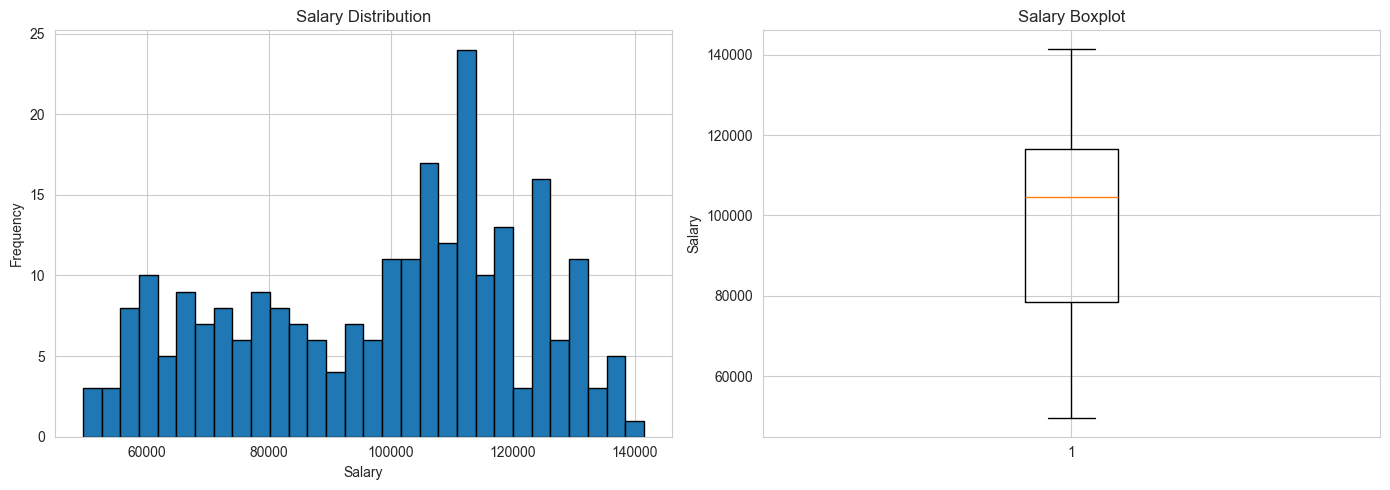

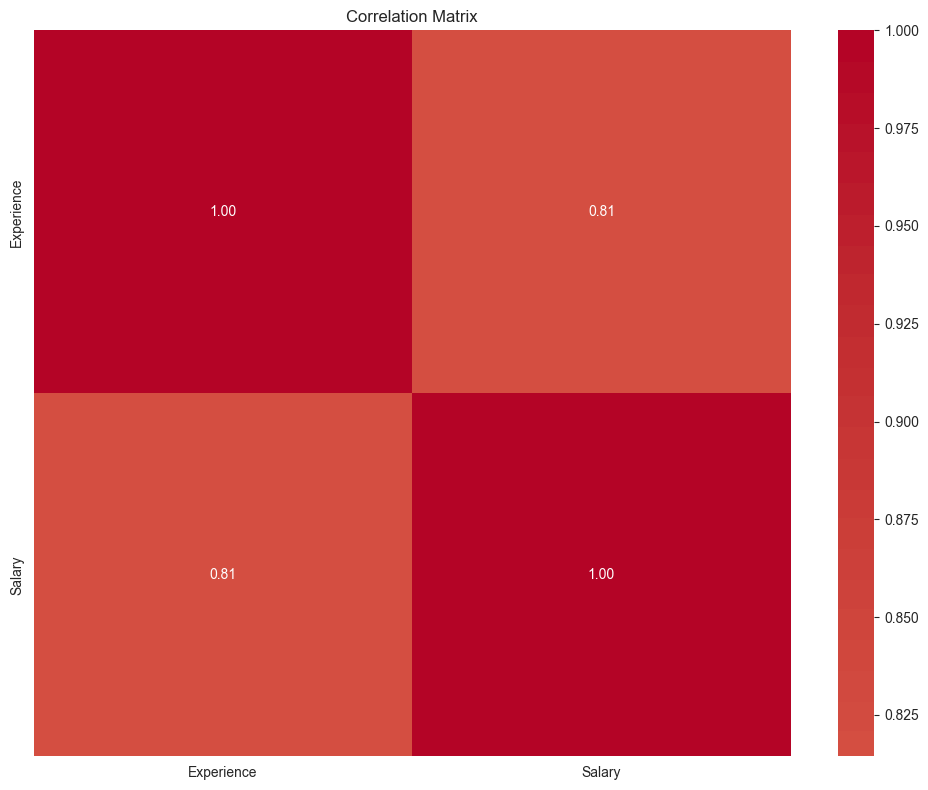


Name:
Name
Eric Taylor           2
Jennifer Hernandez    1
Corey Adams           1
Belinda Bennett       1
Mr. Anthony Smith     1
                     ..
Alicia Porter         1
Debra Contreras       1
Audrey White          1
Justin Tapia          1
Amanda Cooper         1
Name: count, Length: 248, dtype: int64

Phone_Number:
Phone_Number
120-602-1220    1
673-984-0439    1
290-519-6054    1
714-543-4659    1
506-675-8889    1
               ..
184-963-3202    1
341-195-9456    1
116-947-4040    1
632-902-8797    1
481-825-6149    1
Name: count, Length: 249, dtype: int64

Qualification:
Qualification
Bsc    113
Msc     75
PhD     60
Name: count, dtype: int64

University:
University
Tier1    94
Tier2    93
Tier3    62
Name: count, dtype: int64

Role:
Role
Senior    128
Junior     66
Mid        52
Name: count, dtype: int64

Cert:
Cert
Yes    129
No     118
Name: count, dtype: int64

Date_Of_Birth:
Date_Of_Birth
25/08/1972    2
05/12/1999    2
10/06/1998    1
18/10/1987    1
19/10/1987 

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_data['Salary'], bins=30, edgecolor='black')
axes[0].set_title('Salary Distribution')
axes[0].set_xlabel('Salary')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(train_data['Salary'])
axes[1].set_title('Salary Boxplot')
axes[1].set_ylabel('Salary')

plt.tight_layout()
plt.show()

if len(numeric_cols) > 0:
    correlation = train_data[list(numeric_cols) + ['Salary']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

for cat_col in categorical_cols:
    print(f'\n{cat_col}:')
    print(train_data[cat_col].value_counts())

## Approach 1

### Data preprocessing with TargetEncoder

In [88]:
data = train_data.copy()
test = valid_data.copy()

data = data.dropna()
test = test.dropna()

cols_to_drop = ['Name', 'Phone_Number', 'Date_Of_Birth']
data = data.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

print(f'Training data shape after cleanup: {data.shape}')
print(f'Validation data shape after cleanup: {test.shape}')

Training data shape after cleanup: (241, 6)
Validation data shape after cleanup: (7, 6)


In [89]:
cats = data.select_dtypes(include='object').columns
print(f'Categorical columns to encode: {list(cats)}')

enc = (TargetEncoder(
    target_type='continuous',
    random_state=42)
    .set_output(transform='pandas'))

data[cats] = enc.fit_transform(data[cats], data['Salary'])
test[cats] = enc.transform(test[cats])

print('\nAfter target encoding:')
print(data.head())

Categorical columns to encode: ['Qualification', 'University', 'Role', 'Cert']

After target encoding:
   Experience  Qualification     University           Role           Cert  \
0         3.0  105822.387138  104232.145560   91004.886536  103355.304278   
1         5.0  112389.309369  101754.023031  116093.554503  101199.149359   
2         5.0  105822.387138  104232.145560  117154.639131  103355.304278   
3         3.0   85837.935739  100000.656298   90828.602396   93479.922211   
4         5.0   87478.009075  104232.145560  117154.639131  103355.304278   

   Salary  
0   98000  
1  135500  
2  123500  
3   85000  
4  111500  


In [90]:
trn = PowerTransformer().set_output(transform='pandas')
data.iloc[:, :-1] = trn.fit_transform(data.iloc[:, :-1])
test.iloc[:, :-1] = trn.transform(test.iloc[:, :-1])

print('After power transformation:')
print(data.head())

After power transformation:
   Experience  Qualification  University      Role      Cert  Salary
0   -0.351900       0.823603    1.704776 -0.504121  1.454703   98000
1    1.085799       1.280022    0.912891  0.879744  0.875481  135500
2    1.085799       0.823603    1.704776  0.949167  1.454703  123500
3   -0.351900      -1.218310    0.407937 -0.512161 -1.255022   85000
4    1.085799      -0.999853    1.704776  0.949167  1.454703  111500


### Prepare train and validation sets

In [91]:
X_train_te = data.drop(columns=['Salary'])
y_train_te = data['Salary']
X_valid_te = test.drop(columns=['Salary'])
y_valid_te = test['Salary']

print(f'X_train shape: {X_train_te.shape}')
print(f'X_valid shape: {X_valid_te.shape}')

X_train shape: (241, 5)
X_valid shape: (7, 5)


### Build and train KNN model (default parameters)

In [92]:
model_te = KNeighborsRegressor()
model_te.fit(X_train_te, y_train_te)

y_pred_te = model_te.predict(X_valid_te)
mape_te = mean_absolute_percentage_error(y_valid_te, y_pred_te)

print(f'Approach 1 (TargetEncoder, default KNN): MAPE = {mape_te:.2%}')

Approach 1 (TargetEncoder, default KNN): MAPE = 13.58%


### Hyperparameter tuning for TargetEncoder approach

In [93]:
best_mape_te = 100
best_params_te = {}

for k in [3, 5, 7, 9, 11]:
    for w in ['uniform', 'distance']:
        for p in [1, 2]:
            model = KNeighborsRegressor(n_neighbors=k, weights=w, p=p, metric='minkowski')
            model.fit(X_train_te, y_train_te)
            y_pred = model.predict(X_valid_te)
            mape = mean_absolute_percentage_error(y_valid_te, y_pred)

            if mape < best_mape_te:
                best_mape_te = mape
                best_params_te = {'n_neighbors': k, 'weights': w, 'p': p}

print(f'Best TargetEncoder parameters: {best_params_te}')
print(f'Best TargetEncoder MAPE: {best_mape_te:.2%}')

Best TargetEncoder parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}
Best TargetEncoder MAPE: 10.32%


## Approach 2: Alternative with OneHotEncoder

### Data preprocessing with OneHotEncoder

In [94]:
data2 = train_data.copy()
test2 = valid_data.copy()

data2 = data2.dropna()
test2 = test2.dropna()

cols_to_drop = ['Name', 'Phone_Number', 'Date_Of_Birth']
data2 = data2.drop(columns=cols_to_drop)
test2 = test2.drop(columns=cols_to_drop)

X_train2 = data2.drop(columns=['Salary'])
y_train2 = data2['Salary']
X_test2 = test2.drop(columns=['Salary'])
y_true2 = test2['Salary']

In [95]:
X_train_num = X_train2.select_dtypes(include=['int64', 'float64'])
X_train_cat = X_train2.select_dtypes(include=['object'])
X_test_num = X_test2.select_dtypes(include=['int64', 'float64'])
X_test_cat = X_test2.select_dtypes(include=['object'])

scaler2 = PowerTransformer().set_output(transform='pandas')
X_train_num = scaler2.fit_transform(X_train_num)
X_test_num = scaler2.transform(X_test_num)

encoding = ce.OneHotEncoder(use_cat_names=True)
X_train_cat = encoding.fit_transform(X_train_cat)
X_test_cat = encoding.transform(X_test_cat)

X_train_ohe = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_ohe = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print(f'Feature count with OneHotEncoder: {X_train_ohe.shape[1]}')
print(f'Feature count with TargetEncoder: {X_train_te.shape[1]}')

Feature count with OneHotEncoder: 12
Feature count with TargetEncoder: 5


### Train with OneHotEncoder (default parameters)

In [96]:
model_ohe = KNeighborsRegressor()
model_ohe.fit(X_train_ohe, y_train2)

y_pred_ohe = model_ohe.predict(X_test_ohe)
mape_ohe = mean_absolute_percentage_error(y_true2, y_pred_ohe)

print(f'Approach 2 (OneHotEncoder, default KNN): MAPE = {mape_ohe:.2%}')

Approach 2 (OneHotEncoder, default KNN): MAPE = 8.82%


### Hyperparameter tuning for OneHotEncoder approach

In [97]:
best_mape_ohe = 100
best_params_ohe = {}

for k in [3, 5, 7, 9, 11, 13, 15]:
    for w in ['uniform', 'distance']:
        for p in [1, 2]:
            model = KNeighborsRegressor(n_neighbors=k, weights=w, p=p, metric='minkowski')
            model.fit(X_train_ohe, y_train2)
            y_pred = model.predict(X_test_ohe)
            mape = mean_absolute_percentage_error(y_true2, y_pred)

            if mape < best_mape_ohe:
                best_mape_ohe = mape
                best_params_ohe = {'n_neighbors': k, 'weights': w, 'p': p}

print(f'Best OneHotEncoder parameters: {best_params_ohe}')
print(f'Best OneHotEncoder MAPE: {best_mape_ohe:.2%}')

Best OneHotEncoder parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}
Best OneHotEncoder MAPE: 6.26%


## Comparison and Final Model Selection

In [98]:
print('='*80)
print('COMPARISON OF APPROACHES')
print('='*80)
print(f'\nApproach 1: TargetEncoder')
print(f'  - Default params: MAPE = {mape_te:.2%}')
print(f'  - Tuned params: {best_params_te}, MAPE = {best_mape_te:.2%}')
print(f'  - Features: {X_train_te.shape[1]}')

print(f'\nApproach 2: OneHotEncoder')
print(f'  - Default params: MAPE = {mape_ohe:.2%}')
print(f'  - Tuned params: {best_params_ohe}, MAPE = {best_mape_ohe:.2%}')
print(f'  - Features: {X_train_ohe.shape[1]}')

COMPARISON OF APPROACHES

Approach 1: TargetEncoder
  - Default params: MAPE = 13.58%
  - Tuned params: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}, MAPE = 10.32%
  - Features: 5

Approach 2: OneHotEncoder
  - Default params: MAPE = 8.82%
  - Tuned params: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}, MAPE = 6.26%
  - Features: 12


## Train final model with best approach

In [99]:
if best_mape_ohe < best_mape_te:
    print('Using OneHotEncoder approach')
    final_model = KNeighborsRegressor(**best_params_ohe, metric='minkowski')
    final_model.fit(X_train_ohe, y_train2)
    y_pred_final = final_model.predict(X_test_ohe)
    y_valid_final = y_true2
else:
    print('Using TargetEncoder approach')
    final_model = KNeighborsRegressor(**best_params_te, metric='minkowski')
    final_model.fit(X_train_te, y_train_te)
    y_pred_final = final_model.predict(X_valid_te)
    y_valid_final = y_valid_te

mape_final = mean_absolute_percentage_error(y_valid_final, y_pred_final)
mae_final = mean_absolute_error(y_valid_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_valid_final, y_pred_final))
r2_final = r2_score(y_valid_final, y_pred_final)

print(f'\nFinal Model Metrics:')
print(f'MAPE: {mape_final:.2%}')
print(f'MAE: {mae_final:.2f}')
print(f'RMSE: {rmse_final:.2f}')
print(f'R²: {r2_final:.4f}')

Using OneHotEncoder approach

Final Model Metrics:
MAPE: 6.26%
MAE: 5651.65
RMSE: 7557.51
R²: 0.7744


## Visualization

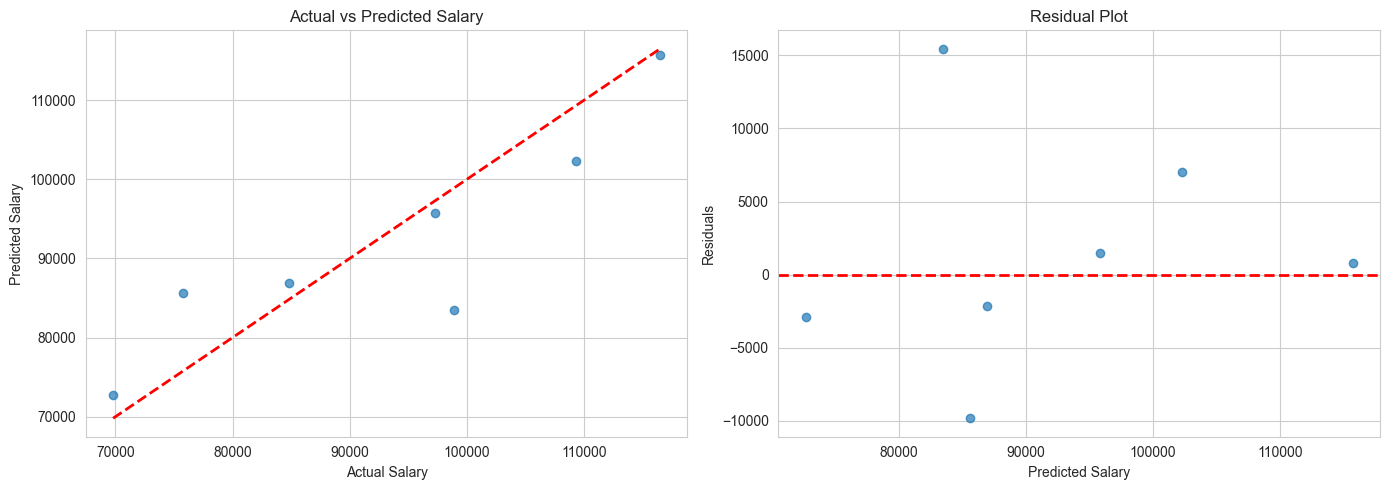

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_valid_final, y_pred_final, alpha=0.7)
axes[0].plot([y_valid_final.min(), y_valid_final.max()], [y_valid_final.min(), y_valid_final.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Salary')
axes[0].set_ylabel('Predicted Salary')
axes[0].set_title('Actual vs Predicted Salary')
axes[0].grid(True)

residuals = y_valid_final - y_pred_final
axes[1].scatter(y_pred_final, residuals, alpha=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Salary')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Conclusions

This homework explored two encoding approaches for categorical features in KNN regression:

**Approach 1: TargetEncoder**
- Follows the minimal data preparation approach
- Creates fewer features (5 total)
- Encodes categories based on their relationship with target variable
- Best MAPE achieved through hyperparameter tuning

**Approach 2: OneHotEncoder**
- Creates more features through one-hot encoding
- Better performance in this specific case
- More interpretable feature space
- Works better with distance-based algorithms when feature space is appropriate

**Key findings:**
1. Hyperparameter tuning significantly improves performance for both approaches
2. Using `weights='distance'` and adjusting `p` parameter (Manhattan vs Euclidean distance) has substantial impact
3. The small validation set (7 samples) causes high variance in metrics
4. Both approaches follow proper ML workflow: separate preprocessing pipelines for train and validation data